In [1]:
import warnings
import time
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as T

# from dask.distributed import Client
# from dask_gateway import GatewayCluster

import pystac_client
import planetary_computer as pc


import sys
import os

current_folder = os.getcwd()
sys.path.insert(0, '/home/jovyan/sdm-geolifeCLEF/raster')
sys.path.insert(0, '/home/jovyan/sdm-geolifeCLEF/models')

from inception_env import InceptionEnv

from torch.optim.lr_scheduler import MultiStepLR

import sys
for path in sys.path:
    print(path)
print(current_folder)    

/home/jovyan/sdm-geolifeCLEF/models
/home/jovyan/sdm-geolifeCLEF/raster
/home/jovyan/sdm-geolifeCLEF/training
/srv/conda/envs/notebook/lib/python39.zip
/srv/conda/envs/notebook/lib/python3.9
/srv/conda/envs/notebook/lib/python3.9/lib-dynload

/srv/conda/envs/notebook/lib/python3.9/site-packages
/home/jovyan/sdm-geolifeCLEF/training


In [2]:
torch.__version__

'1.12.1.post200'

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2
from zarr_dataset import Zarr_Dataset

# Read Zarr Dataset

## KDE

In [5]:
LOCAL_FILES = True

BUCKET_NAME = 'datasets-sdm'
folder_f = 'geoLifeCLEF/features'
folder_l = 'geoLifeCLEF/labels'
# s3://datasets-sdm/geoLifeCLEF/features/
filename_train_f = 'train_ca_6000m_64px_features.zarr'
filename_train_l = 'geolifeclef_ca_0.05deg_kde_0.1deg_epanechnikov.zarr'
filename_val_f   = 'val_ca.zarr'
filename_val_l   = 'ca_val_obs_val.zarr'
s3_train_path_f  = 's3://{}/{}/{}'.format(BUCKET_NAME, folder_f, filename_train_f)
s3_train_path_l  = 's3://{}/{}/{}'.format(BUCKET_NAME, folder_l, filename_train_l)
s3_val_path_f    = 's3://{}/{}/{}'.format(BUCKET_NAME, folder_f, filename_val_f)
s3_val_path_l    = 's3://{}/{}/{}'.format(BUCKET_NAME, folder_l, filename_val_l)

local_val_path = '../data/val_ca.zarr'
local_train_path_f = '../data/features/train_ca_6000m_64px_features.zarr'
local_train_path_l = '../data/labels/train_ca_0.05deg_kde_0.1deg_ep_labels.zarr'
local_val_path_f = None
local_val_path_l = None

if LOCAL_FILES:
    train_path_f, train_path_l = local_train_path_f, local_train_path_l
    val_path_f, val_path_l = local_val_path_f, local_val_path_l
else:
    train_path_f, train_path_l = s3_train_path_f, s3_train_path_l
    val_path_f, val_path_l = s3_val_path_f, s3_val_path_l
    


# s3_example_path = 's3://{}/{}/example.zarr'.format(BUCKET_NAME, folder_f)

print("Train paths: ", train_path_f, train_path_l)
print("Val paths  : ", val_path_f, val_path_l)

Train paths:  ../data/features/train_ca_6000m_64px_features.zarr ../data/labels/train_ca_0.05deg_kde_0.1deg_ep_labels.zarr
Val paths  :  None None


## Setup Train dataset and dataloader

In [6]:
# train_dataset = Zarr_Dataset(s3_train_path)
train_dataset = Zarr_Dataset(filepath_f=train_path_f, filepath_l=train_path_l)

In [7]:
train_dataset.info()

Features:
  Type               : zarr.core.Array
Data type          : object
Shape              : (17173,)
Chunk shape        : (1,)
Order              : C
Read-only          : True
Filter [0]         : Pickle(protocol=5)
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Synchronizer type  : zarr.sync.ThreadSynchronizer
Store type         : zarr.storage.DirectoryStore
No. bytes          : 137384 (134.2K)
No. bytes stored   : 14156117517 (13.2G)
Storage ratio      : 0.0
Chunks initialized : 17173/17173

Labels:
  Type               : zarr.core.Array
Data type          : object
Shape              : (17173,)
Chunk shape        : (1,)
Order              : C
Read-only          : True
Filter [0]         : Pickle(protocol=5)
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Synchronizer type  : zarr.sync.ThreadSynchronizer
Store type         : zarr.storage.DirectoryStore
No. bytes          : 137384 (134.2K)
No. bytes stored   : 27818

In [8]:
len(train_dataset)

17173

### Quick test

In [9]:
p,t = train_dataset[13]

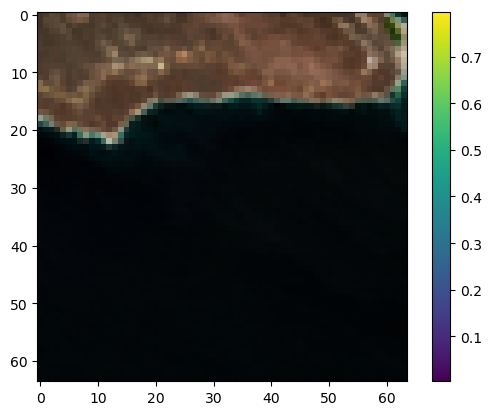

In [10]:
img = p[0:3,:,:]
plt.imshow(img.permute(1, 2, 0))
plt.colorbar()
plt.show()

(tensor(0.3929), tensor(0.))

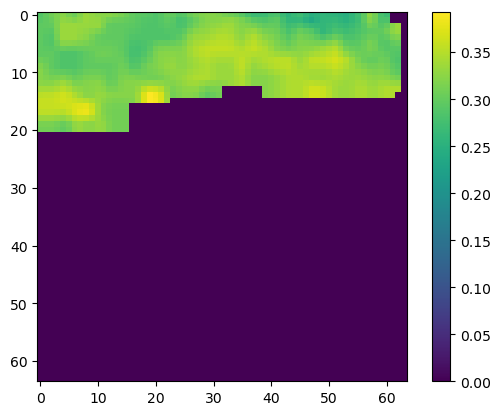

In [11]:
idx = -5
ped = p[idx].unsqueeze(dim=0)#-> Remove first dim (channel) 
plt.imshow(ped.permute(1, 2, 0))#, vmax=1.0)
plt.colorbar()
p[idx].max(), p[idx].min()

In [12]:
demo = train_dataset[0]
N_LABELS = demo[1].shape[0]
N_INPUTS = demo[0].shape[0]
N_LABELS, N_INPUTS

(5079, 31)

### Convenience functions

In [13]:
def AccuracyTopK(predictions, labels, k:int=30, one_hot:bool=True):

    """Returns a '1' for every time a value in the top-k of predicitons is present in the 
       top-k of labels. This is then normalized by the number of predictions
       results can have a maximum value of 1.0
       params:
           - predictions: tensor of [batch_size, num_classes]
           - labels: tensor of [batch_size, num_classes]
    """
    
    res = 0.
    batch_size = labels.shape[0]
    
    
    
    for i, pred in enumerate(predictions):
        top_k_preds = np.argpartition(pred,-k)[-k:]
        
        if not one_hot:
            top_k_labels = np.argpartition(labels[i],-k)[-k:]

            if top_k_preds in top_k_labels:
                res += 1.
        else:
            # There's only one-winner for 1 hot encoded
            # top_k_labels = np.argpartition(labels[i],-1)[-1:]
            top_k_labels = np.argmax(labels[i])
            
            if top_k_labels in top_k_preds:
                res += 1.
                # print("[{}] top_k label = {} | top_k preds = {}".format(i,top_k_labels,top_k_preds))
                # print (res, labels.shape[0])
    return res / labels.shape[0]

In [14]:
def predict(model, loader, device, batch_size, validation_size=-1):
    """
        Give the prediction of the model on a test set
        :param model: the model
        :param test_loader: the test set loader
        :param validation_size: number of occurrences for the validation
    """
    
    validation_size = validation_size / batch_size if validation_size > -1 else -1
    
    with torch.no_grad():
        
        model.eval()

        y_preds = []
        y_labels = []
        count = 0
        
        for inputs, labels in tqdm(loader, leave=False):
            
            y_labels.extend(labels)
            
            # inputs, labels = inputs.type(torch.cuda.FloatTensor).to(device), labels.to(device)
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            
            # if(count % 100 == 0):
            #     print(outputs.shape, outputs.dtype)
                
            y_preds.extend(outputs.cpu())

            # y_preds.extend(outputs.cpu().tolist())
            # y_preds.extend(outputs.data.tolist())
            # y_labels.extend(labels)

            count += 1
            if validation_size > -1 and count >= validation_size:
                break

        predictions, labels = np.asarray(y_preds, dtype=object), np.asarray(y_labels, dtype=object)

    return predictions, labels

In [15]:
from tqdm.notebook import tqdm
def validate (num_epochs, model, device, loader, batch_size=32, validation_size=-1, top_k=[30]):
    
    # model = model.to(device)
    
    for epoch in tqdm(range(num_epochs)):

        predictions, labels = predict(model, loader, device, batch_size, validation_size)

        # evatuate
        res = []
        for k in top_k:
            acc = AccuracyTopK(predictions, labels, k)
            res.append(acc*100.)
            print("Accuracy[top_k={}] = {:.4}%".format(k,res[-1]))

In [ ]:
def save_model(PATH, model, optimizer):
    
    if scheduler:
        ssd = scheduler.state_dict()
    else:
        ssd = None
        
    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': ssd,
            'loss': train_loss,
            'NUM_EPOCHS' : NUM_EPOCHS,
            'BATCH_SIZE' : BATCH_SIZE,
            'GAMMA' : GAMMA,
            'LR' : LR,
            'MODEL': MODEL,
            'OPTIM' : OPTIM
            }, PATH)
    
    
def load_model(PATH):
    checkpoint = torch.load(PATH)
    
    NUM_EPOCHS = checkpoint['NUM_EPOCHS'] if checkpoint['NUM_EPOCHS'] else None 
    BATCH_SIZE = checkpoint['BATCH_SIZE'] if checkpoint['BATCH_SIZE'] else None
    GAMMA      = checkpoint['GAMMA'] if checkpoint['GAMMA'] else None
    LR         = checkpoint['LR'] if checkpoint['LR'] else 1e-3
    MODEL      = checkpoint['MODEL'] if checkpoint['MODEL'] else 'inet'
    OPTIM      = checkpoint['OPTIM'] if checkpoint['OPTIM'] else 'AdamW'
    
    print("Epochs:{} | Batch_size: {} | Gamma: {} | LR: {} | Model: {} | Optim: {}"\
          .format(NUM_EPOCHS, BATCH_SIZE, GAMMA, LR, MODEL, OPTIM))
    
    if MODEL == 'inet':
        model = InceptionEnv(dropout=DROPOUT, n_labels=N_LABELS, n_input=N_INPUTS)
        print("Loading InceptioNet")
        
    model.load_state_dict(checkpoint['model_state_dict'])
        
    if OPTIM == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
        print("Optimizer: SGD")
    else:
        optimizer = torch.optim.AdamW(model.parameters(), lr=LR, betas=(0.9, 0.95), weight_decay=0.1)
        print ("Optimizer:AdamW")
        
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    if checkpoint['scheduler_state_dict']:
        scheduler = MultiStepLR(optimizer, milestones=iterations, gamma=GAMMA)
        print("Scheduler: MultiStepLR")
    else :
        scheduler = None
        

    train_loss = checkpoint['loss']
    
    print("Train loss sequence: \n", train_loss)
    
    return model, optimizer, scheduler, train_loss


# Train/predict setup

## Train the model

In [34]:
# from train import fit
# from predict import predict
from evaluation import evaluate
from metrics import ValidationAccuracyMultipleBySpecies
from metrics import ValidationAccuracyMultiple


BATCH_SIZE = 128
NUM_WORKERS = 8


iterations = [20,40,60,80,100]#,140,160,180,200]
#test
# iterations = [1]
NUM_EPOCHS = iterations[-1]

LOG_MODULO = 50 #
VAL_MODULO = 5

# LR = 5e-4 * batch_size / 256
GAMMA = 0.1
DROPOUT = 0.7

MODEL = 'inet'
OPTIM = 'SGD' #'AdamW'

# evaluation
# METRICS = (ValidationAccuracyMultipleBySpecies([30]), ValidationAccuracyMultiple([30]))
# METRICS = (ValidationAccuracyMultiple([30,50]))

In [35]:
import gc
# inet.to('cpu')
# del inet
# del train_set#, val_set
# del train_loader#, val_loader
# del val_dataset, val_loader
gc.collect()

235

In [36]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [37]:
most_recent_loss = None
train_loss = []
completed_epochs = 0

In [38]:
inet = InceptionEnv(dropout=DROPOUT, n_labels=N_LABELS, n_input=N_INPUTS)
inet

InceptionNet in mlmc mode

In [39]:
criterion = torch.nn.CrossEntropyLoss()


if OPTIM == 'SGD':
    LR = 0.1  #always use this with a scheduler which will decay the LR every some epoch
    optimizer = torch.optim.SGD(inet.parameters(), lr=LR, momentum=0.9)
    
else:
    LR = 0.1
    optimizer = torch.optim.AdamW(inet.parameters(), lr=LR, betas=(0.9, 0.95), weight_decay=GAMMA)
    
    
scheduler = MultiStepLR(optimizer, milestones=iterations, gamma=GAMMA)



In [40]:
from tqdm.notebook import tqdm
import time

def train(model, train_loader, val_loader, num_epochs, criterion, optimizer, scheduler=None, completed_epochs=0, val_modulo=1):
    
    print('beginning to train model')
    model = model.to(device)
    
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0
        start_time = time.perf_counter()
        for inputs, labels in tqdm(train_loader, leave=False):
            # print("Train loop dtypes: ", inputs.dtype, labels.dtype)
            inputs, labels = inputs.type(torch.cuda.FloatTensor).to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
         
        # completed_epochs += 1
        
        if scheduler:
            scheduler.step()
            
        end_time = time.perf_counter()
        duration = end_time - start_time
        #train_acc = compute_accuracy(model, train_loader)
        # val_acc = compute_accuracy(model, val_loader)
        
        train_loss.append(running_loss / len(train_loader))
        
        most_recent_loss = train_loss[-1]
        
        if val_loader and epoch % val_modulo == 0:
            validate(1, model, val_loader, device, validation_size=1000)
        
        completed_epochs = epoch+1
        print("Epoch: {0:02d} | Training Loss: {1:.5f} | Time: {2:.3f}".format(completed_epochs, most_recent_loss, duration))
        

In [41]:
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

In [42]:
len(train_loader)

135

In [ ]:
train(model=inet, train_loader=train_loader, val_loader=None, num_epochs=NUM_EPOCHS, criterion=criterion, optimizer=optimizer, scheduler=scheduler, completed_epochs=completed_epochs)
# train(inet, train_loader, None, NUM_EPOCHS, criterion, optimizer)

beginning to train model


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 01 | Training Loss: 1991.52359 | Time: 171.958


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 02 | Training Loss: 1979.54124 | Time: 174.865


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 03 | Training Loss: 1982.00810 | Time: 174.849


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 04 | Training Loss: 1978.08708 | Time: 174.795


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 05 | Training Loss: 1978.02690 | Time: 174.736


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 06 | Training Loss: 1977.45002 | Time: 174.769


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 07 | Training Loss: 1976.09328 | Time: 174.803


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 08 | Training Loss: 1973.97205 | Time: 174.514


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 09 | Training Loss: 1972.41056 | Time: 174.819


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 10 | Training Loss: 1975.29433 | Time: 174.839


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 11 | Training Loss: 1972.75216 | Time: 174.527


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 12 | Training Loss: 1973.72677 | Time: 174.488


  0%|          | 0/135 [00:00<?, ?it/s]

## Save model states

In [ ]:
import datetime
date = datetime.datetime.strptime(str(datetime.datetime.now()), "%Y-%m-%d  %H:%M:%S.%f")

filename_model = 'inet_{}{}{}-{}{}-b{}-e{}-{}.tar'.format(date.year, date.month, date.day, date.hour, date.minute, BATCH_SIZE, completed_epochs, OPTIM)
filename_model

In [ ]:
BUCKET_NAME = 'datasets-sdm2'
folder = 'geoLifeCLEF/models/inet'
# s3://datasets-sdm2/geoLifeCLEF/models/inet/

s3_model_path  = 's3://{}/{}/{}'.format(BUCKET_NAME, folder, filename_model)
local_model_path = 'models/' + filename_model
s3_model_path, local_model_path


In [ ]:
save_model(filename_model, inet, optimizer)


# Setup Validation dataset and dataloader

## Validate 

Ascertain accuracy of models

Load model from memory

### Load val dataset into memory from s3

In [8]:
BUCKET_NAME = 'datasets-sdm'
folder_f = 'geoLifeCLEF/features'
folder_l = 'geoLifeCLEF/labels'

filename_val_f   = 'val_ca.zarr'
filename_val_l   = 'ca_val_obs.zarr'

s3_val_path_f    = 's3://{}/{}/{}'.format(BUCKET_NAME, folder_f, filename_val_f)
s3_val_path_l    = 's3://{}/{}/{}'.format(BUCKET_NAME, folder_l, filename_val_l)
s3_val_path_f, s3_val_path_l

('s3://datasets-sdm/geoLifeCLEF/features/val_ca.zarr',
 's3://datasets-sdm/geoLifeCLEF/labels/ca_val_obs_val.zarr')

In [12]:
%%time
val_dataset = Zarr_Dataset(s3_val_path_f, s3_val_path_l, persist=True)
# val_dataset = Zarr_Dataset(s3_example_path)

CPU times: user 24.4 s, sys: 4.63 s, total: 29 s
Wall time: 3min 59s


In [13]:
val_dataset.features.shape, val_dataset.labels.shape

((5025,), (5025,))

In [58]:
len(val_dataset)

5025

### Load into val dataloader

In [14]:
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=True, batch_size=64, num_workers=4)

### Display datasets

In [60]:
%%time
# (patch, target) = train_set[2708]
(patch, target) = val_dataset[2708]

NameError: name 'val_dataset' is not defined

In [61]:
patch[4:,:,:].max(), patch[4:,:,:].min(), patch[0:3,:,:].max(), patch[0:3,:,:].min(), patch[3,:,:].max(), patch[3,:,:].min(), len(target)

(tensor(0.8316),
 tensor(0.),
 tensor(0.8706),
 tensor(0.0196),
 tensor(0.3333),
 tensor(0.0030),
 5079)

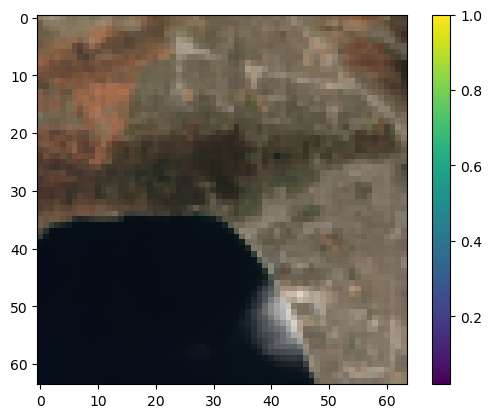

In [62]:
img = patch[0:3,:,:]
plt.imshow(img.permute(1, 2, 0), vmax=1)
plt.colorbar()
plt.show()

(tensor(0.3333), tensor(0.3333))

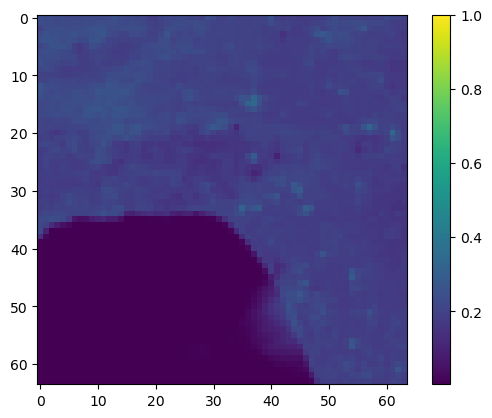

In [53]:
NIR_image = patch[3].unsqueeze(dim=0)#-> Remove first dim (channel) 
plt.imshow(NIR_image.permute(1, 2, 0),vmax=1)#, vmax=1.0)
plt.colorbar()
NIR_image.max(), patch[3].max()

(tensor(0.0030), tensor(0.3333))

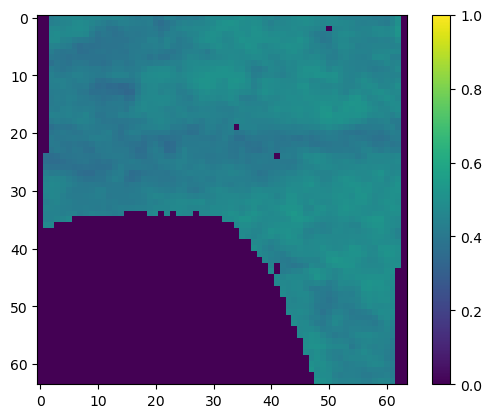

In [52]:
ped = patch[-1].unsqueeze(dim=0)#-> Remove first dim (channel) 
plt.imshow(ped.permute(1, 2, 0),vmax=1)#, vmax=1.0)
plt.colorbar()
patch[3].min(), patch[3].max()

In [2]:
N_LABELS = 5079
N_INPUTS = 31
GAMMA = 0.1
DROPOUT = 0.7
NUM_WORKERS = 8
BATCH_SIZE = 64

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [23]:
model_path = 'inet_20221211-14-59.pt'
model_path = 'inet_20221211-5-38.pt'
model_path = 'inet_20221211-21-9.pt'
dict_path = 'inet_20221212-124-b128-e0-SGD.tar'
dict_path = 'inet_20221212-1441-b128-e200-SGD.tar'

inet, optimizer, scheduler, train_loss = load_model(dict_path)

Epochs:200 | Batch_size: 128 | Gamma: 0.1 | LR: 0.1 | Model: inet | Optim: SGD
Loading InceptioNet
Optimizer: SGD
Scheduler: MultiStepLR


In [24]:
inet = inet.to(device)

In [25]:
inet

InceptionNet in mlmc mode

In [26]:
validate(num_epochs=1, model=inet, loader=val_loader, device=device, validation_size=-1, top_k=[1,5,10,20,30,50,100])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

/tmp/ipykernel_12969/2675298953.py:41: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  predictions, labels = np.asarray(y_preds, dtype=object), np.asarray(y_labels, dtype=object)


Accuracy[top_k=30] = 3.423%
Accuracy[top_k=50] = 5.632%
Accuracy[top_k=100] = 10.67%


In [55]:
del val_loader, val_dataset
gc.collect()

29121

## Test BCELoss

In [ ]:
targets = ca_val_gdf.drop(['geometry'], axis=1).to_numpy()
targets

In [ ]:
import torch.nn.functional as F
batch_size = 8

loss_fn = torch.nn.BCELoss()

# outputs_before_sigmoid = torch.randn(batch_size, num_classes)
fake_output = torch.randn(num_classes, dtype=float)
sigmoid_outputs = torch.sigmoid(fake_output)
softmax_outputs = F.softmax(fake_output, dim=-1)


#or perfect guess
outputs = torch.from_numpy(targets[5])

target = torch.from_numpy(targets[5])
# target_classes = torch.randint(0, 2, (batch_size, num_classes),dtype=torch.float)  # randints in [0, 2).

# target_classes = torch.tensor([[1.0],[0.0]])
# sigmoid_outputs = torch.tensor([[0.8],[0.]])
print(len(sigmoid_outputs), len(target))
print(type(sigmoid_outputs), type(torch.from_numpy(targets[5])))
loss = loss_fn(sigmoid_outputs, target)
loss2 = loss_fn(softmax_outputs, target)
# loss = loss_fn(outputs, target)
print(loss, loss2)

In [ ]:
sigmoid_outputs.sum(), target.sum(), softmax_outputs.sum()

In [ ]:
fake_output

In [ ]:
import zarr
import numcodecs

In [ ]:
z = zarr.empty(1, dtype=object, object_codec=numcodecs.Pickle())
z[0] = [patch, 

In [ ]:
z[0]

# Original Training for InceptioNet

### Debug: setting paths for imports

In [ ]:
import sys
for path in sys.path:
    print(path)
    

In [ ]:
# sys.path.remove('/models')
# sys.path.remove('/raster')
# sys.path.remove('model/')
sys.path.remove('/home/jovyan/sdm-geolifeCLEF/../raster')
# sys.path.remove('/models')
# sys.path.remove('/raster')
